In [1]:
import mlflow
import pandas as pd
import pickle
from pathlib import Path
import lightgbm as lgbm
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit 
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sbn
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from mlflow.models.signature import infer_signature

# Multiple outputs per notebook cell
%config InteractiveShell.ast_node_interactivity = 'all'

# random_state for different processes
RANDOM_STATE = 221

In [2]:
def num_rows_horizon(df, timeframe='7day'):
    ''' 
    Input: Dataframe, Timeframe (in to_timedelta format)
    Output: Outputs number of rows in dataframe to reach timeframe
    '''
    return len(df.loc[df['day'] > (df['day'].max() - pd.to_timedelta('7day'))])

# validate test
def trainval_test_split(df):
    '''
    Input: Dataframe from features prep
    Output: Train and final test sets with a 7 day window
    '''
    train_validate = df.loc[df['day'] < (df['day'].max() - pd.to_timedelta('7day'))]
    final_test = df.loc[df['day'] > (df['day'].max() - pd.to_timedelta('8day'))]

    return train_validate, final_test

# train validate
def load_train_test(df, drop_index=True):
    ''' 
    Input: Dataframe from features prep
    Output: Data prepared for hyperparameter search
    '''
    X = (df.drop(columns=['load_actual', 'country', 'day']) 
           .dropna() # remove NAs from creating lagged variables
           .reset_index()
           )
    if drop_index:
        X = X.drop(columns='utc_timestamp')
     
    y = (df.reset_index(drop=True)[['load_actual']])
    
    return X, y


### Load Data
- Creating train/test and validation sets, then ensure windows are correct

In [3]:
cd = Path.cwd()
data_dir = str(cd.parents[1])
upsampled = data_dir + '/datasets/country_energy/load_wthr_downsample.pickle'
downsampled = data_dir + '/datasets/country_energy/load_wthr_upsample.pickle'

# Xu - upsampled
with open(upsampled, 'rb') as f:
    Xu = pickle.load(f)

# Xd - downsampled
with open(downsampled, 'rb') as f:
    Xd = pickle.load(f)

# Create test/train and validation set. Ensure dates are correct
final_test_u = Xu.loc[Xu['day'] > (Xu['day'].max() - pd.to_timedelta('8day'))] # 8 days is selected because last day 2019-4-30 has 0 hours
Xu_check = Xu.loc[Xu['day'] < (Xu['day'].max() - pd.to_timedelta('7day'))]
print(f'Ensure validation set is last 7 days; min date: {final_test_u.index.min()}, max date: {final_test_u.index.max()}')
print(f'Ensure train/test set excludes last 7 days; min date: {Xu_check.index.min()}, max date: {Xu_check.index.max()}')

final_test_d = Xd.loc[Xd['day'] > (Xd['day'].max() - pd.to_timedelta('8day'))]
Xd_check = Xd.loc[Xd['day'] < (Xd['day'].max() - pd.to_timedelta('7day'))]
print(f'Ensure validation set is last 7 days; min date: {final_test_d.index.min()}, max date: {final_test_d.index.max()}')
print(f'Ensure train/test set excludes last 7 days; min date: {Xd_check.index.min()}, max date: {Xd_check.index.max()}')

Ensure validation set is last 7 days; min date: 2019-04-23 00:00:00+00:00, max date: 2019-04-30 00:00:00+00:00
Ensure train/test set excludes last 7 days; min date: 2015-01-15 00:00:00+00:00, max date: 2019-04-22 23:45:00+00:00
Ensure validation set is last 7 days; min date: 2019-04-23 00:00:00+00:00, max date: 2019-04-30 00:00:00+00:00
Ensure train/test set excludes last 7 days; min date: 2015-01-15 00:00:00+00:00, max date: 2019-04-22 23:00:00+00:00


Prepare Data for Model Training

Objective Function (LightGBM) -- consider adding timing param within mlflow (assuming mlflow doesn't already track that)

In [8]:
def objective(params, x, y, n_splits=10): # n_splits=10, params, # adjust x, y being the upsample and downsample datasets
#def objective():
    # Time Series splits for cross validation 
    num_rows_horizon = len(x.loc[x['day'] > (x['day'].max() - pd.to_timedelta('7day'))])
    ts_cv = TimeSeriesSplit(n_splits=10, test_size=num_rows_horizon) 
    folds = []
    fold_mae = []
    fold_mape = []

    # drop unneeded day variable
    x = x.drop(columns='day')

    # start run with ml flow, record metrics
    # try this: mlflow.autolog()
    with mlflow.start_run(nested=False): #nested=True
        # params = {
        # # 'n_estimators': trial.suggest_int('n_estimators', 100, 1000), # adjust
        # 'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.5),
        # 'num_leaves': trial.suggest_int('num_leaves', 31, 511), # adjust
        # 'max_depth': trial.suggest_int('max_depth', 3, 9), # adjust if overfit
        # # 'subsample': trial.suggest_float('subsample', 0.5, 1), # research
        # # 'colsample_bytree': trial.suggest-float('colsample_bytree', 0.7, 1),
        # # 'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        # # 'reg_lambda': trial.suggest_float('reg_lambda', 0, 1)
        # }
        
        mlflow.log_params(params)

        # early stoppin gcallback
        early_stopping = lgbm.early_stopping(5) # verbose=False 
        
        # Dataset splits for nested cross-validation
        for i, (train_idx, test_idx) in enumerate(ts_cv.split(x)):
            X_train, X_test = x.iloc[train_idx], x.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            
            # model, model fit, and predictions
                # partial w/ params?
            model = lgbm.LGBMRegressor(
                **params, 
                random_state=RANDOM_STATE, 
                n_jobs=-1,
                callbacks = [early_stopping]
                # num_threads, # set to number of real cpu cores available
                # for distribtued training https://lightgbm.readthedocs.io/en/latest/Parallel-Learning-Guide.html
                #callbacks = [early_stopping(5)],
 # early_stopping_min_delta 
                )  # path_smooth 
            model.fit(X_train, y_train) # has no attribute append
            y_pred = model.predict(X_test)

            # loss metrics
            mae = mean_absolute_error(y_test, y_pred)
            mape = mean_absolute_percentage_error(y_test, y_pred)

            # record loss metrics for mean
            folds.append(i+1)
            fold_mae.append(mae)
            fold_mape.append(mape)
    
        # log mean / std of folds
        avg_mae = np.mean(fold_mae)
        std_mae = np.std(fold_mae)
        avg_mape = np.mean(fold_mape)
        std_mape = np.std(fold_mape)
        mlflow.log_metrics({
            'avg_mae': avg_mae,
            'std_mae': std_mae,
            'avg_mape': avg_mape,
            'std_mape': std_mape,   
        })

        # fold level results
        tbl = pd.DataFrame({'folds': folds, 
                            'mae_per_fold': fold_mae,
                            "mape_per_fold": fold_mape}).round(4)
        mlflow.log_table(data=tbl, artifact_file='results_per_fold.json')
        
    mlflow.end_run()
    return {'avg_mae': avg_mae, 'std_mae': std_mae, 'avg_mape': avg_mape, 'std_mape': std_mape}
    #return avg_mape



Model Training and Hyperparameter Selection

Pre-Optimization Preparation

Hyperparameter optimization, logging with Mlflow

In [6]:
def test_hype_opt(dataset, country, iterations=3, nested_windows=10):
    # Split into training/validation and test sets
    train, test = trainval_test_split(dataset)
    # Prepare Training Data
    X_train, y_train = load_train_test(train)

    # Nested timeseries split for cross validation
    nrow = num_rows_horizon(dataset, timeframe='7day')
    ts_cv = TimeSeriesSplit(n_splits=nested_windows, test_size=nrow)

    # Model and callbacks
    early_stopping = lgbm.early_stopping(5)
    model = lgbm.LGBMRegressor(
                    random_state=RANDOM_STATE, 
                    n_jobs=-1,
                    callbacks=[early_stopping],
                    #verbosity=1
                    )
    
    # # Parameter set / ranges
    params = {
        'learning_rate': Real(0.001, 2, 'uniform'),
        'reg_alpha': Real(0, 1, 'uniform'),
        'num_leaves': Integer(20, 500, 'uniform'), # adjust
        'max_depth': Integer(3, 9, 'uniform'), # adjust if overfit
        #'subsample': Real(0.5, 1, 'uniform'), # research
        'colsample_bytree': Real(0.7, 1, 'uniform'),
        'reg_alpha': Real(0, 1, 'uniform'),
        'min_data_in_leaf': Integer(20, 100, 'uniform')
    } # reduce training time
    # path_smooth

    # # BayesSearch of optimal params
    bayes_opt = BayesSearchCV(
        model,
        params,
        cv=ts_cv,
        n_iter=iterations, # 50, 100
        scoring='neg_mean_absolute_percentage_error', # 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error'
        n_jobs=-1,
        random_state=RANDOM_STATE,
        return_train_score=True,
        optimizer_kwargs = {'base_estimator': 'RF'},
        verbose = 1
    )
    #return model
    # # Run and time bayesian optimization of params
    start = time.time()
    opt_model = bayes_opt.fit(X_train, y_train)
    end = round(time.time() - start, 2)
    # # Variable Importance Plot
    importance_plot = lgbm.plot_importance(bayes_opt.best_estimator_, 
                                            figsize=(8,5), 
                                            title=f'{country} Variable Importance')
    # # Get predictions of optimal set of params for final test set
    X_test, y_test = load_train_test(test, drop_index=False)
    y_pred = opt_model.best_estimator_.predict(X_test.drop(columns='utc_timestamp'))
    y_test = np.reshape(y_test, (len(y_test),))
    final_mape = mean_absolute_percentage_error(y_test, y_pred)  
    print(final_mape)
    # # Time Series plot of Predicted Vs Actuals
    plot_dt = pd.DataFrame({'Day': X_test['utc_timestamp'],
                            'actual': np.reshape(y_test, (len(y_test),)), 
                            'predicted': y_pred})

    test_plot = plt.figure(figsize=(10,5))
    _ = sbn.lineplot(data=plot_dt, 
                    x='Day', 
                    y='actual', 
                    color='red', 
                    label='Actuals')
    _ = sbn.lineplot(data=plot_dt, 
                    x='Day', 
                    y='predicted', 
                    color='grey', 
                    label='Predicted')
    _ = plt.ylabel('Load (MW)')
    _ = plt.title(f'Predicted Vs. Actual Load for {country}') # 'For {Country}'

In [ ]:
testt = test_hype_opt(Xu.loc[Xu.country == 'DE'], country='Deutshland')
testt
#opt_model = test_hype_opt(Xu.loc[Xu.country == 'DE'], country='Deutshland')
# opt_model.best_params_
# opt_model.best_estimator_

In [57]:
### Unsure what the this does, but will try it
# from mlflow.models.signature import infer_signature

def optimization_logs(opt_model, importance_plot, test_plot, bayes_opt, final_mape, final_mae, end, country):
    # params
    mlflow.log_params(opt_model.best_params_)
    # best params in training
    mlflow.log_table(opt_model.best_params_, f'{country}_best_params.json')
    # variable importance plot
    mlflow.log_figure(importance_plot.figure, f'{country}_variable_importance.png')
    # predicted versus actuals
    mlflow.log_figure(test_plot, f'{country}_predicted_vs_actuals.png') 
    # metrics
    mlflow.log_metrics({
                    'optimization_training_time': end,
                    'best_training_mape': abs(bayes_opt.best_score_),
                    'final_mape': final_mape,
                    'final_mae': final_mae
                })
    # Save model
    # mlflow.sklearn.log_model(sk_model=opt_model.best_estimator_, 
    #                           #registered_model_name=f"./{country}_best_model",
    #                           artifact_path=f"{country}_best_model"
    #                           )
    # consider trying model signature
    

# ... Seeking best set of models?
def hyperparam_opt(dataset, dataset_name, country, iterations=25, nested_windows=10):
    with mlflow.start_run(nested=True, run_name=f"{dataset_name}, {country} optimized model"):

        # Autolog experiments
        # mlflow.autolog(log_models=True, 
        #                log_datasets=True,
        #                silent=True,
        #                #exclude_flavors=True,
        #                log_input_examples=False,
        #                log_model_signatures=False,
        #                log_traces=False,)
        
        # Split into training/validation and test sets
        train, test = trainval_test_split(dataset)
        # Prepare Training Data
        nrow = num_rows_horizon(dataset, timeframe='7day')
        X_train, y_train = load_train_test(train)

        # Nested timeseries split for cross validation
        ts_cv = TimeSeriesSplit(n_splits=nested_windows, test_size=nrow)

        # Model and callbacks
        early_stopping = lgbm.early_stopping(5)
        model = lgbm.LGBMRegressor(
                        random_state=RANDOM_STATE, 
                        n_jobs=-1,
                        callbacks=[early_stopping],
                        verbosity=-1
                        )
        
        # Parameter set / ranges
        params = {
            'learning_rate': Real(0.001, 2, 'uniform'),
            'reg_alpha': Real(0, 1, 'uniform'),
            'num_leaves': Integer(20, 500, 'uniform'), # adjust
            'max_depth': Integer(3, 9, 'uniform'), # adjust if overfit
            #'subsample': Real(0.5, 1, 'uniform'), # research
            'colsample_bytree': Real(0.7, 1, 'uniform'),
            'reg_alpha': Real(0, 1, 'uniform'),
            'min_data_in_leaf': Integer(20, 100, 'uniform')
        } # reduce training time
        # path_smooth

        # BayesSearch of optimal params
        bayes_opt = BayesSearchCV(
            model,
            params,
            cv=ts_cv,
            n_iter=iterations, # 50, 100
            scoring='neg_mean_absolute_percentage_error', # 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error'
            n_jobs=-1,
            random_state=RANDOM_STATE,
            return_train_score=True,
            optimizer_kwargs={'base_estimator': 'RF'},
            #verbose=1
        )

        # Run and time bayesian optimization of params
        start = time.time()
        opt_model = bayes_opt.fit(X_train, y_train)
        end = round(time.time() - start, 2)

        # Variable Importance Plot
        importance_plot = lgbm.plot_importance(bayes_opt.best_estimator_, 
                                                figsize=(8,5), 
                                                title=f'{country} Variable Importance')
        
        # Get predictions of optimal set of params for final test set
        X_test, y_test = load_train_test(test, drop_index=False)
        y_pred = opt_model.best_estimator_.predict(X_test.drop(columns='utc_timestamp'))
        y_test = np.reshape(y_test, (len(y_test),))
        final_mape = mean_absolute_percentage_error(y_test, y_pred)  
        final_mae = mean_absolute_error(y_test, y_pred)

        # Time Series plot of Predicted Vs Actuals
        plot_dt = pd.DataFrame({'Day': X_test['utc_timestamp'],
                                'actual': np.reshape(y_test, (len(y_test),)), 
                                'predicted': y_pred})

        test_plot = plt.figure(figsize=(10,5))
        _ = sbn.lineplot(data=plot_dt, 
                        x='Day', 
                        y='actual', 
                        color='red', 
                        label='Actuals')
        _ = sbn.lineplot(data=plot_dt, 
                        x='Day', 
                        y='predicted', 
                        color='grey', 
                        label='Predicted')
        _ = plt.ylabel('Load (MW)')
        _ = plt.title(f'{country}: Predicted Vs. Actual Load') # 'For {Country}'

        # Log params, result metrics, and visualizations
        optimization_logs(opt_model, 
                          importance_plot, 
                          test_plot, 
                          bayes_opt, 
                          final_mape, 
                          final_mae,
                          end, 
                          country)

In [30]:

# datasets = [Xd, Xu]
# dataset_names = ['Xd', 'Xu']
# Track Optimized Country Level models, metrics, and visualizations
def automated_forecast(datasets, dataset_names, iter_per_model=25, nested_windows=10, experiment_name='No experiment name given'):
    '''
    datasets
    dataset_names
    iter_per_model
    nested_windows
    experiment_name
    '''
    if __name__ == "__main__":
    #try:
        mlflow.set_tracking_uri("http://127.0.0.1:5000")
        mlflow.set_experiment(experiment_name)

        for name, data in zip(dataset_names, datasets):
            # does this need to be nested? 
            mlflow.start_run(#nested=True, # with mlflow.start_run(run_name=run_name) as run
                             run_name=f'{name} Country Energy Forcast')

            # Group data, begin process for each group in data
            country_data = data.groupby('country')

            for country, data in country_data: 
                with mlflow.start_run(nested=True, run_name=f"Country: {country}"): # with mlflow.start_run(run_name=run_name) as run
                    # Begin optimization process for country level data
                    # Definitely need run name here when this process is kicked off (country name)
                    hyperparam_opt(data, country, iterations=iter_per_model, nested_windows=nested_windows) # consider including country in the optimization for titles and metric logging  
            
            # End run for that dataset
            mlflow.end_run()
    
        
    # end mlflow run if an exception occurs
    # except:
    #     mlflow.end_run()


In [55]:
# Version 2 (country -> datasets)
# datasets = [Xd, Xu]
# dataset_names = ['Xd', 'Xu']
# Track Optimized Country Level models, metrics, and visualizations

from time import strftime

def automated_forecast(datasets, dataset_names, iter_per_model=25, nested_windows=10, experiment_name='No experiment name given'):
    '''
    datasets
    dataset_names
    iter_per_model
    nested_windows
    experiment_name
    '''
    if __name__ == "__main__":
        mlflow.set_tracking_uri("http://127.0.0.1:5000")
        mlflow.set_experiment(experiment_name)
        
        with mlflow.start_run(run_name=f"Model Per Country at {strftime("%d-%b %H:%M")}"):
            
            for data, name in zip(datasets, dataset_names):
                # Group data, begin process for each group in data
                country_data = data.groupby('country')

                for country, data in country_data: 
                    # with mlflow.start_run(#nested=True, 
                    #                     run_name=f"Country: {country}"): # with mlflow.start_run(run_name=run_name) as run
                        # Begin optimization process for country level data
                        # Definitely need run name here when this process is kicked off (country name)
                        # mlflow.start_run(nested=True, run_name=f"{country} optimized model"
                    hyperparam_opt(data, name, country, iterations=iter_per_model, nested_windows=nested_windows)

            # End run for that dataset

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
🏃 View run 1hour, AT optimized model at: http://127.0.0.1:5000/#/experiments/491771817017301243/runs/0ff33ca748dd453e9b310addea8a9b79
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/491771817017301243
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
🏃 View run 1hour, BE optimized model at: http://127.0.0.1:5000/#/experiments/491771817017301243/runs/06947f79631446f69728ea1031eba80e
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/491771817017301243
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
🏃 View run 1hour, DE optimized model at: http://127.0.0.1:5000/#/experiments/491771817017301243/runs/2a76c09528424e2aa1ed109afcfb0df7
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/491771817017301243
F

c:\Users\WulfN\Python Projects\venv\Lib\site-packages\lightgbm\plotting.py:137: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  _, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)


🏃 View run 15min, LU optimized model at: http://127.0.0.1:5000/#/experiments/491771817017301243/runs/3a6c87b1c4964617a3b522fade33378f
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/491771817017301243
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
🏃 View run 15min, NL optimized model at: http://127.0.0.1:5000/#/experiments/491771817017301243/runs/7ae92b95f7c1433db9228207beab2405
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/491771817017301243
🏃 View run Model Per Country at 05-Mar 08:25 at: http://127.0.0.1:5000/#/experiments/491771817017301243/runs/ff54c19176b4458c98e6e304bf4758df
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/491771817017301243


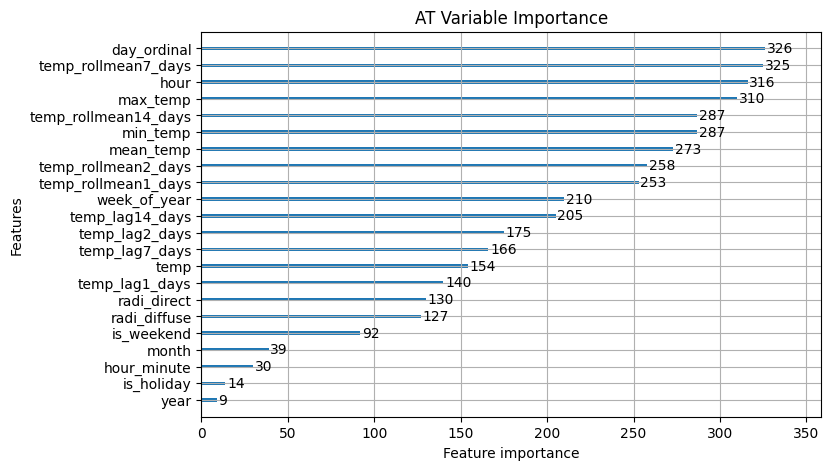

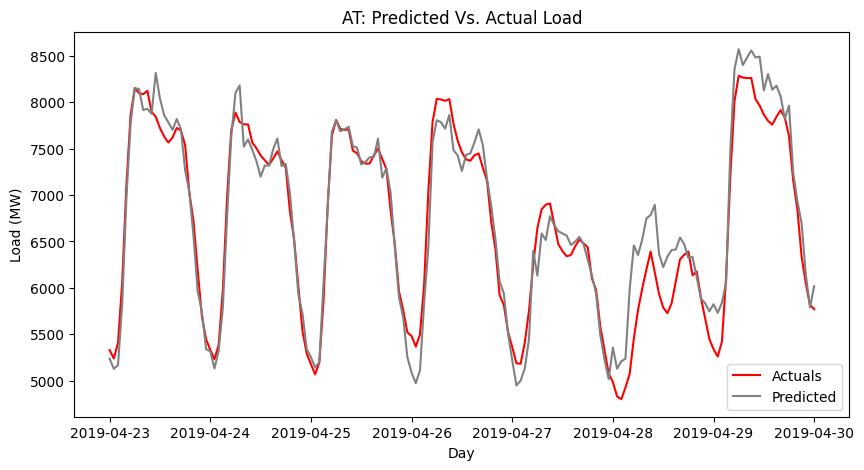

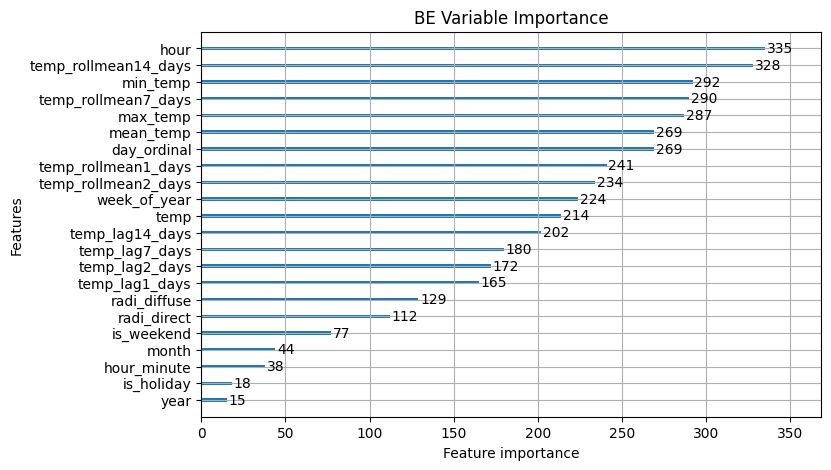

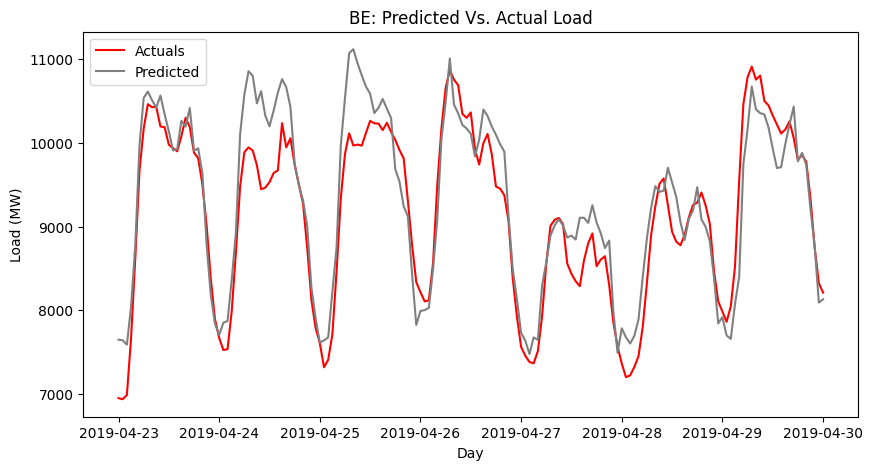

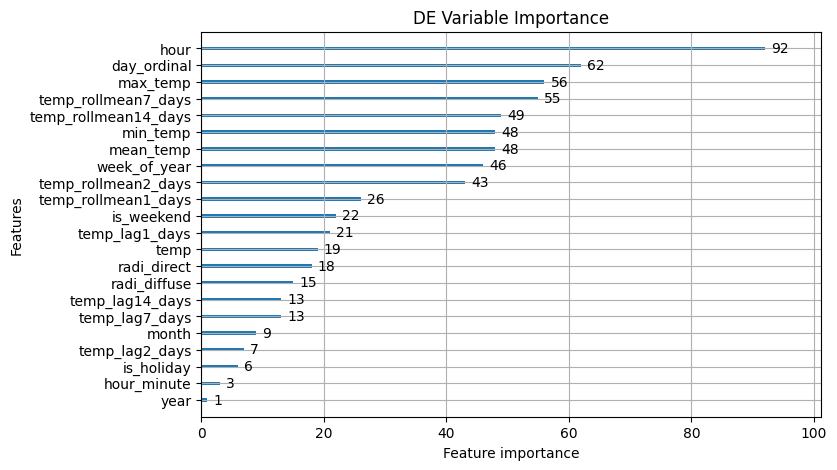

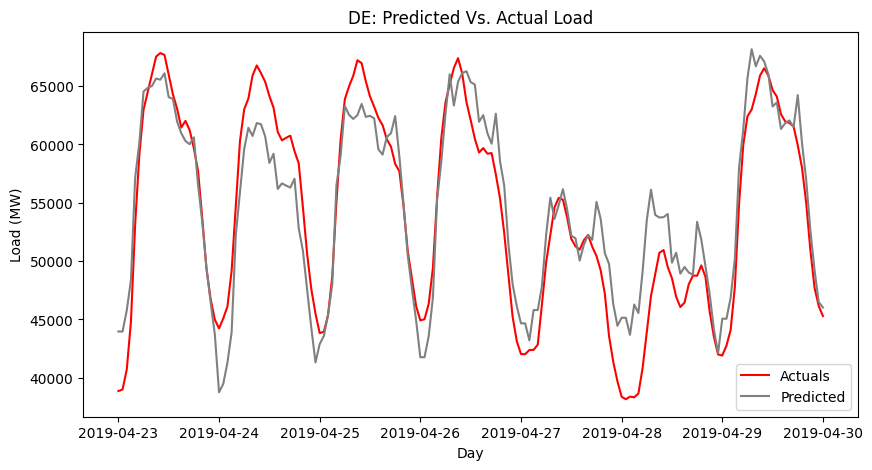

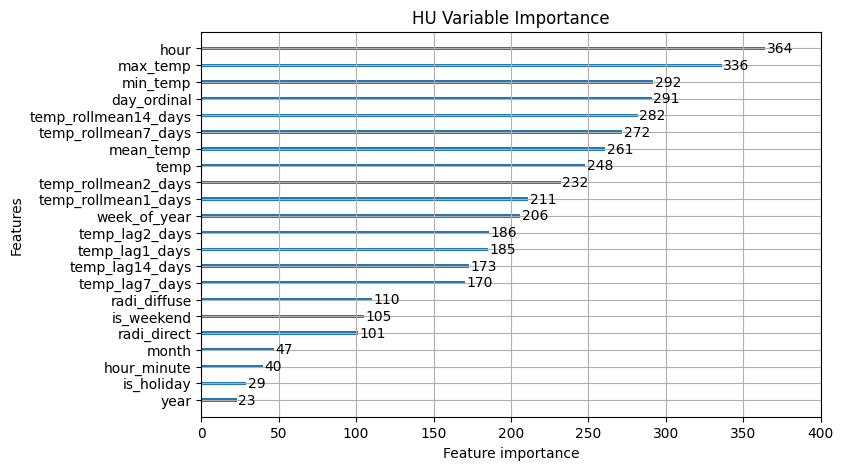

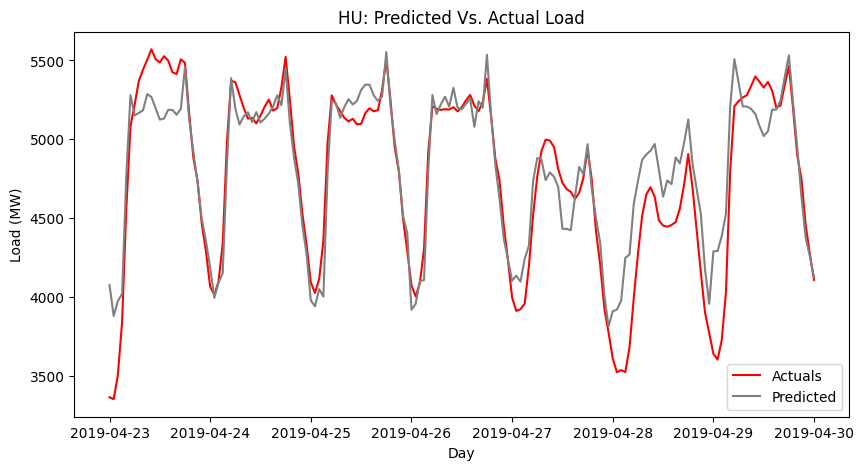

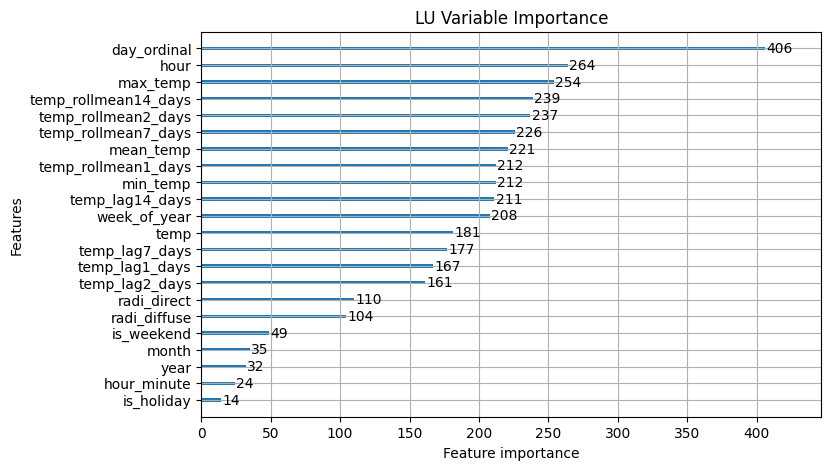

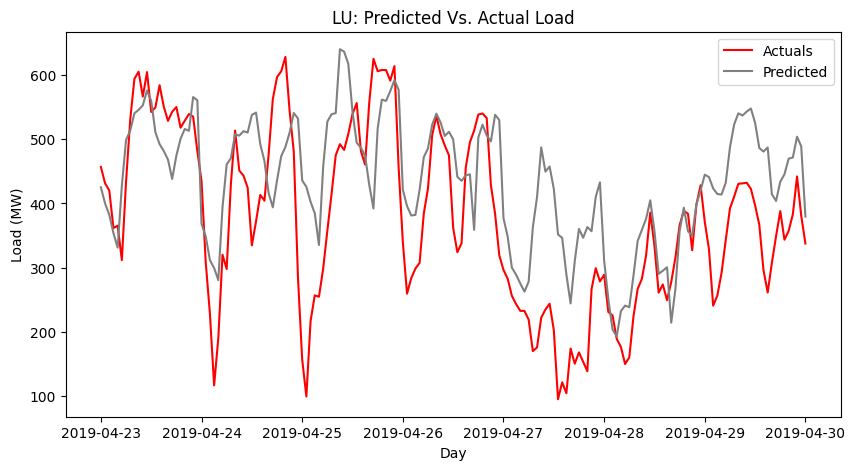

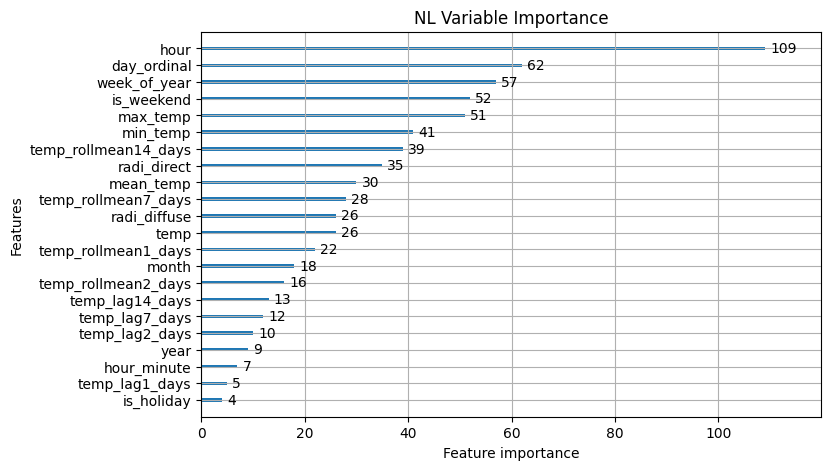

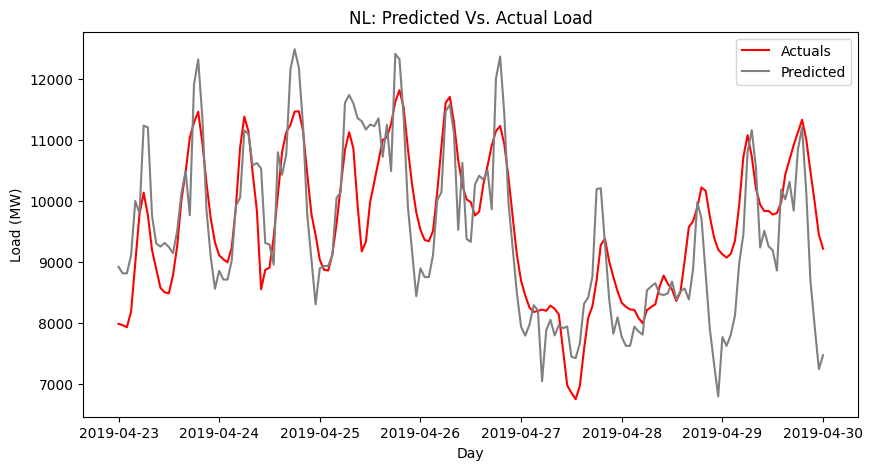

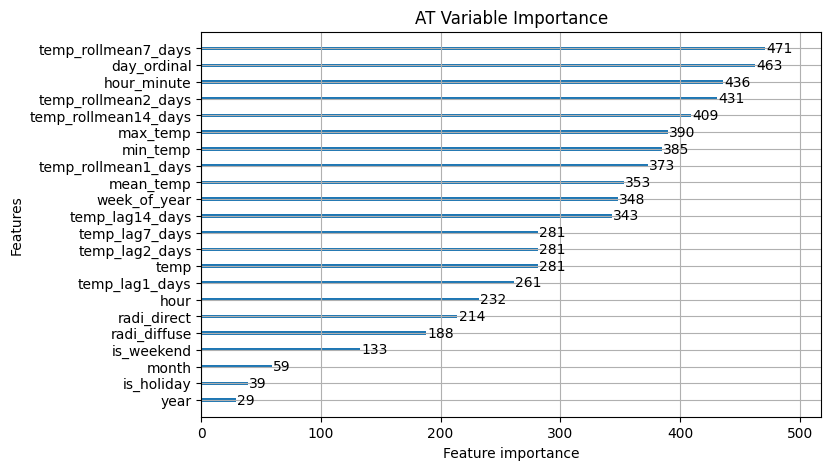

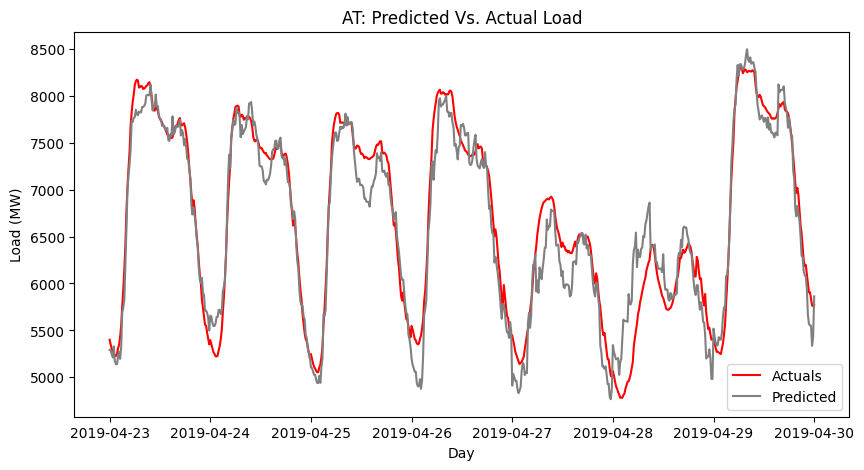

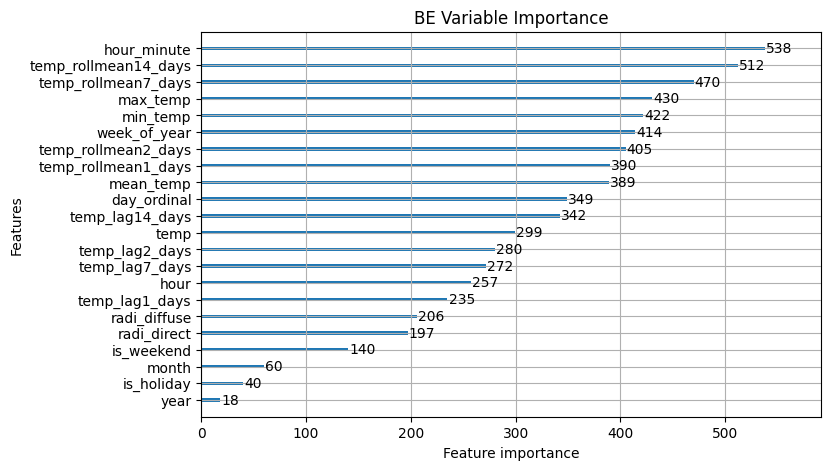

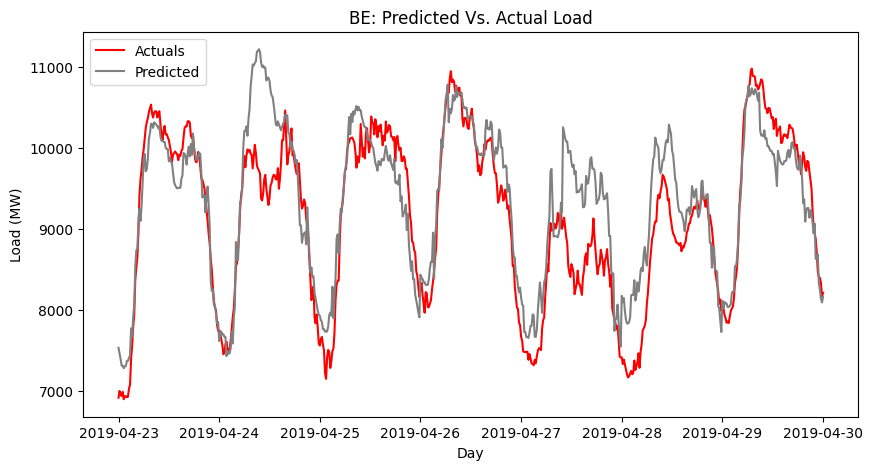

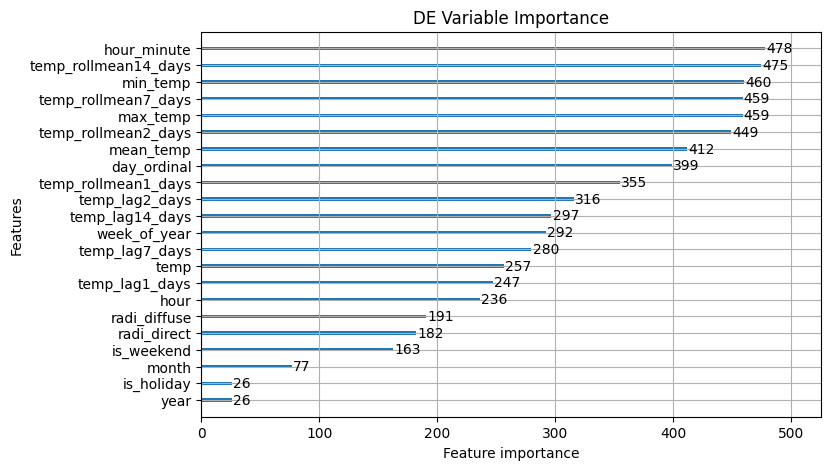

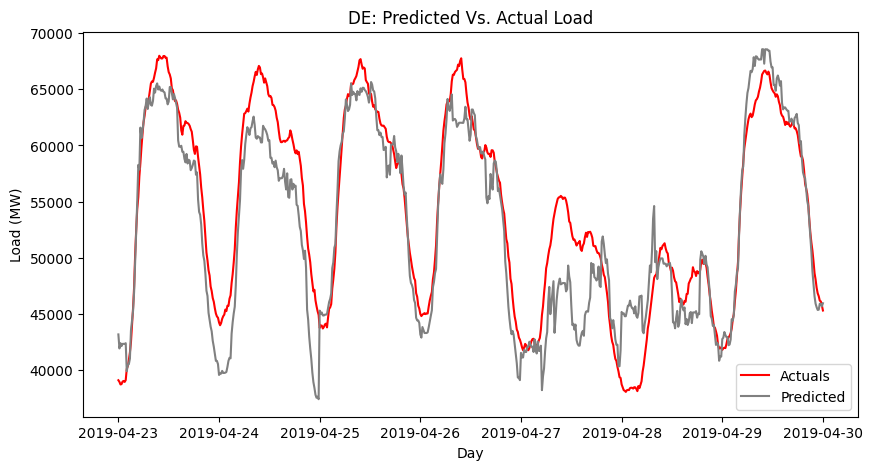

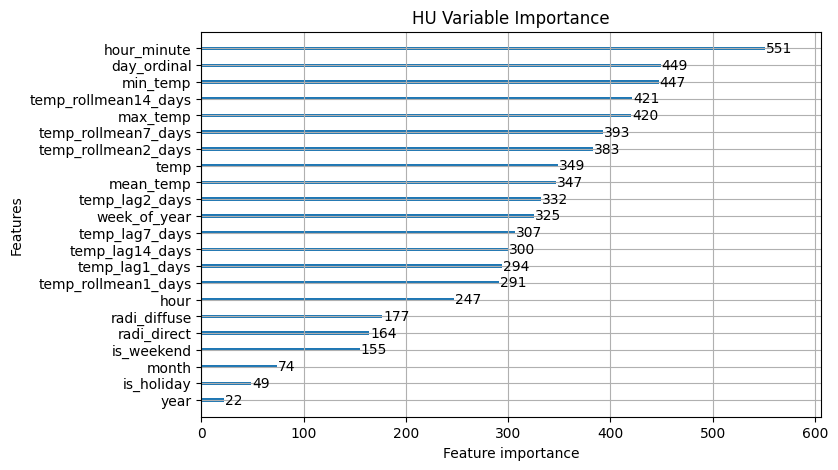

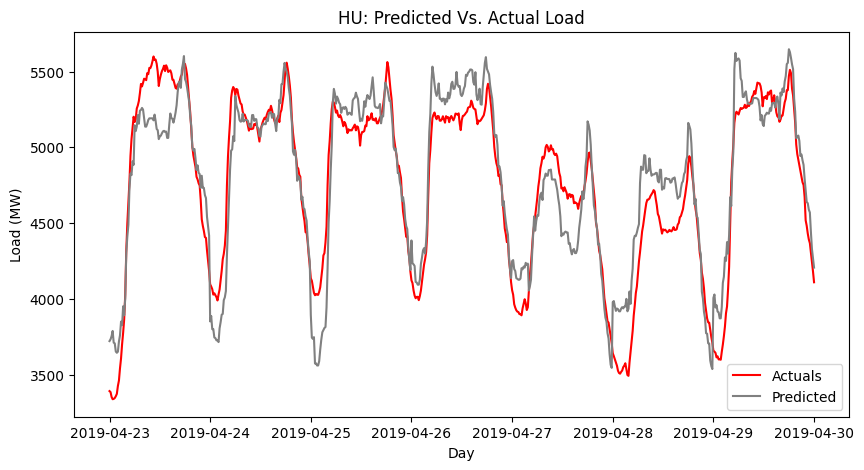

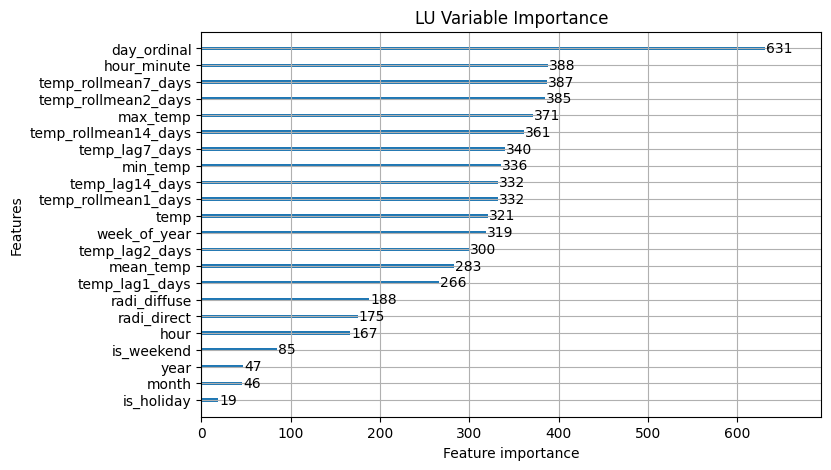

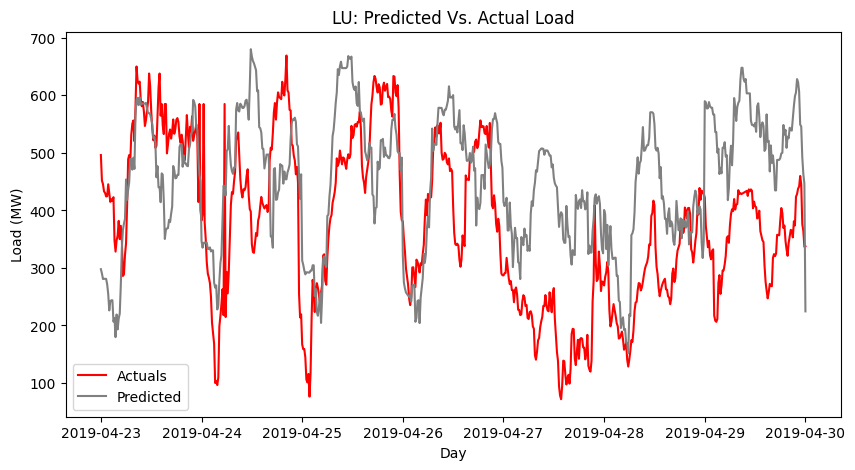

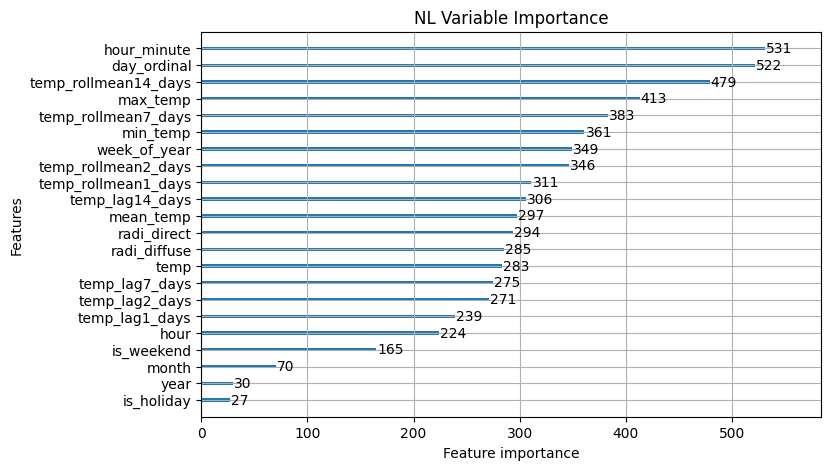

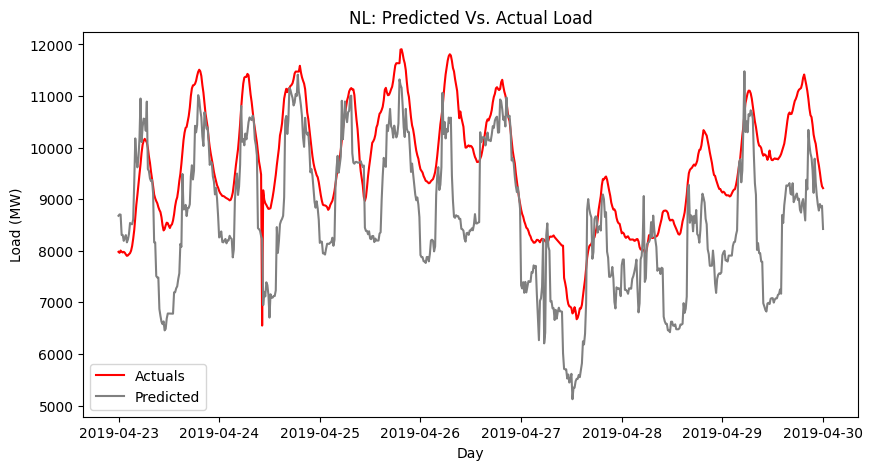

In [56]:
# automated_forecast(datasets=[Xd, Xu], 
#                    dataset_names=['Xd: downsampled', 'Xu: upsampled'], 
#                    iter_per_model=2, 
#                    experiment_name='Optimized Models by Country: Test')

# - miniature grid search to how number of iterations in bayesian optimization affects the final mape
# - experimenting with nested_window try seperately
# - testing MLflow to see how I can compare these runs
# iter_try = [5,10,20,40]
# nested_window_try = [5,10,20,40]
# Could create a grid search of this

# for iteration in iter_try:

mlflow.end_run()

automated_forecast(datasets=[Xd, Xu], 
                   dataset_names=['1hour', '15min'],
                   iter_per_model=2, #15, # iteration, 
                   experiment_name=f'auto_data_test',#f'Upsample; {iter_try[0]} iterations',
                   nested_windows=10)

# May need to grid search nest number of iterations per model, and nested windows


# Goals: 
# Have comparisons between all countries (correctly nested)
# Have clear comparisons between the different datasets
# Get optimal number of windows



[LightGBM] [Warning] Unknown parameter: callbacks
[LightGBM] [Warning] Unknown parameter: object
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Warning] Unknown parameter: 0x000002AD57893800>
[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87


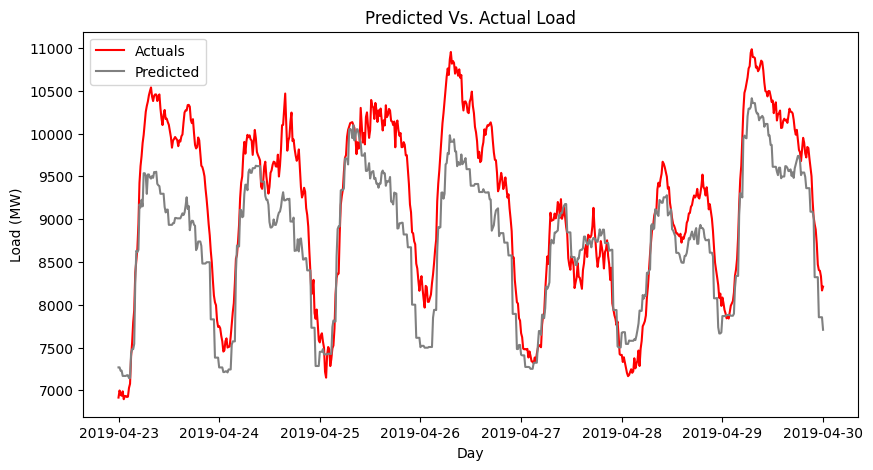

In [ ]:
def hyperparam_opt(params, ts_cv, model):
    mlflow.log_params(params)

    # Optimization params
    #iteration_number = 10 # ------
    opt = BayesSearchCV(
        model,
        params,
        cv=ts_cv,
        n_iter=iteration_number, # 50, 100
        scoring='neg_mean_absolute_percentage_error', # 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error'
        n_jobs=-1,
        random_state=RANDOM_STATE,
        return_train_score=True,
        # keep_training_booster=True,
        optimizer_kwargs = {'base_estimator': 'RF'},
    )

    # Run and time bayesian optimization of params
    start = time.time()
    opt_model = opt.fit(X_train, y_train)
    end = round(time.time() - start, 2)


# function for naming model runs

def model_results():
    # Logging the best params
    mlflow.log_table(opt_model.best_params_, artifact_file='best_params.json')

    # Variable Importance Plot
    importance_plot = lgbm.plot_importance(opt.best_estimator_, figsize=(8,5))
    mlflow.log_figure(importance_plot.figure, 'variable_importance.png') 
    
    # Get predictions of optimal set of params for final test set
    X_test, y_test = country_train_test(final_test_u, drop_index=False)
    y_pred = opt_model.best_estimator_.predict(X_test.drop(columns='utc_timestamp'))
    y_test = np.reshape(y_test, (673,))
    final_mape = mean_absolute_percentage_error(y_test, y_pred)  

    # Time Series plot of Predicted Vs Actuals
    plot_dt = pd.DataFrame({'Day': X_test['utc_timestamp'],
                            'actual': np.reshape(y_test, (673,)),
                            'predicted': y_pred})

    test_plot = plt.figure(figsize=(10,5))
    _ = sbn.lineplot(data=plot_dt, 
                     x='Day', 
                     y='actual', 
                     color='red', 
                     label='Actuals')
    _ = sbn.lineplot(data=plot_dt, 
                     x='Day', 
                     y='predicted', 
                     color='grey', 
                     label='Predicted')
    _ = plt.ylabel('Load (MW)')
    _ = plt.title('Predicted Vs. Actual Load') # 'For {Country}'
    # log time series actual versus predicted
    mlflow.log_figure(test_plot, 'predicted_vs_actuals.png') 
    
    # Record Training Metrics
    mlflow.log_metrics({
            'optimization_iteration_number': iteration_number,
            'training_time': end,
            'best_training_mape': abs(opt.best_score_),
            'final_test_mape': final_mape,
        })

Optimized Model Final Test Set Performance and Visualizations

In [ ]:
### Functionalize model, then run with lags removed from the dataset

Results Graphs (MLflow)

Best Model on final validation set